In [6]:
import os
import argparse

from os.path import join as ospj
from os.path import expanduser
from munch import Munch as mch
import numpy as np
import matplotlib.pyplot as plt

from ProbVLM.src.utils import load_data_loader

from ProbVLM.src.ds import prepare_coco_dataloaders

from ProbVLM.src.networks import *
from ProbVLM.src.train_probVLM import *
import clip
from CLIP_prefix_caption.train import *

from utils import *


class OneAgent(nn.Module):
    def __init__(self,):
        super().__init__()
        self.ProbVLM_Net = BayesCap_for_CLIP(inp_dim=512, out_dim=512, hid_dim=256, num_layers=3, p_drop=0.05,)
        self.ProbVLM_Net.load_state_dict(torch.load("models/_last_agent_C.pth"))
        self.ProbVLM_Net.eval()
        self.CLIP_Net, self.preprocess = clip.load("ViT-B/32", device='cuda')
        self.CLIP_Net = self.CLIP_Net.float()
        self.CLIP_Net.eval()
        self.prefix_length = 40
        self.prefix_length = 40
        self.prefix_length_clip = 40
        self.prefix_dim = 512
        self.num_layers = 8
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.ClipCap = ClipCaptionPrefix(self.prefix_length, self.prefix_length_clip, self.prefix_dim, self.num_layers,"mlp")
        self.w = torch.randint(0, 50257, (15000, 77)).long().cuda()
        self.GGL = GenGaussLoss()
        # self.ClipCap.load_state_dict(torch.load('CLIP_prefix_caption/coco_train/coco_prefix_latest.pt'))

    def image_encoder(self,o):
        with torch.no_grad():
            z = self.CLIP_Net.encode_image(o)
            mu_img, alpha_img, sigma_img = self.ProbVLM_Net.img_BayesCap(z)
        return mu_img, alpha_img, sigma_img
    
    def text_encoder(self,w):
        with torch.no_grad():
            z = self.CLIP_Net.encode_text(w)
            mu_cap, alpha_cap, sigma_cap = self.ProbVLM_Net.txt_BayesCap(z)
        return mu_cap, alpha_cap, sigma_cap
    
    def text_decoder(self, z):
        with torch.no_grad():
            prefix_embed = self.ClipCap.clip_project(z.float())
            prefix_embed = prefix_embed.reshape(1, self.prefix_length, -1)
            t = generate2(self.ClipCap, self.tokenizer, embed=prefix_embed)
        return t
    
    def perception(self, dataloader): # tempral version of perception
        z = []
        for i, (o, w) in enumerate(dataloader):
            mu_img, alpha_img, sigma_img = self.image_encoder(o)
            z.append(mu_img)
        self.z = torch.cat(z, dim=0)
    
    def propose(self, index):
        with torch.no_grad():            
            w = self.text_decoder(self.z[index])
        return w
    
    def judge(self, index, proposed_w):
        with torch.no_grad():
            mu_Sp, alpha_Sp, beta_Sp = self.text_encoder(proposed_w)
            mu_Li, alpha_Li, beta_Li = self.image_encoder(self.w[index])

            p_li = self.GGL(mu_Li, alpha_Li, beta_Li, self.z[index])
            p_sp = self.GGL(mu_Sp, alpha_Sp, beta_Sp, self.z[index])
            r = np.exp(np.min([0,(p_sp-p_li).item()]))
            u = np.random.rand(len(r),)
            self.w[u < r] = proposed_w[u < r].cpu().detach()    
    


In [5]:
dataset = 'coco' # coco or flickr

data_dir = ospj('dataset/', dataset) # e.g. ospj(expanduser('~'), 'Documents', 'jm', 'data', dataset)
dataloader_config = mch({
    'batch_size': 8,
    'random_erasing_prob': 0.,
    'traindata_shuffle': True
})
from ProbVLM.src.utils import load_data_loader
loaders = load_data_loader(dataset, data_dir, dataloader_config)
coco_train_loader, coco_valid_loader, coco_test_loader = loaders['train'], loaders['val'], loaders['test']

test_data = next(iter(coco_test_loader))
print(test_data[1].shape)


creating index...
index created!
Loading COCO Caption: n_images 113287 n_captions 566435...
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading COCO Caption: n_images 1000 n_captions 5000...
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
Loading COCO Caption: n_images 5000 n_captions 25000...
torch.Size([8, 77])


In [3]:
agent = OneAgent()
agent = agent.cuda()
agent.eval()

OneAgent(
  (ProbVLM_Net): BayesCap_for_CLIP(
    (img_BayesCap): BayesCap_MLP(
      (mod): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Dropout(p=0.05, inplace=False)
        (5): Linear(in_features=256, out_features=512, bias=True)
      )
      (block_mu): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (block_alpha): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
      (block_beta): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
      )
    )
    

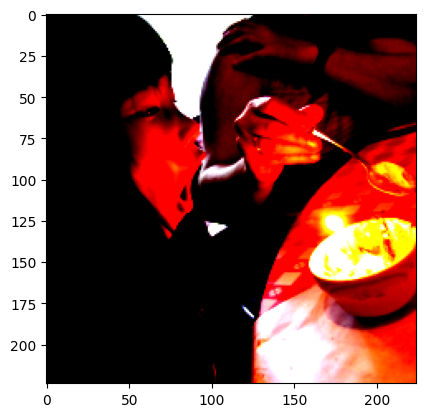

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

torch.Size([1, 50257])
tensor([[393]], device='cuda:0')
torch.Size([1, 50257])
tensor([[262]], device='cuda:0')
torch.Size([1, 50257])
tensor([[13]], device='cuda:0')
 or the.
tensor([[49406,   541,   518,   269, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')
tensor([ 0.0685, -0.0276,  0.0202, -0.1754,  0.0358, -0.1178, -0.1789, -1.8686,
        -0.0205,  0.1835], device='cuda:0')
tensor([637.4216, 627.7713, 582.1577, 624.7527, 545.8851, 597.8785, 57

In [4]:
img = test_data[0][7].cuda().unsqueeze(0)

plt.imshow(img[0].permute(1,2,0).cpu().numpy())
plt.show()
mu_img, alpha_img, sigma_img = agent.image_encoder(img)
t = agent.text_decoder(mu_img)
print(t)

tokenizer = tokenize
prefix = tokenizer(t).cuda()
print(prefix)
mu_cap, alpha_cap, sigma_cap = agent.text_encoder(prefix)
print(mu_cap[0][:10])
print(alpha_cap[0][:10])
print(sigma_cap[0][:10])